# Contents
- Preprocess
- Implementation
- Ranking Metrics
- Evaluation
- Prediction
- Reference

In [1]:
import os
import sys
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numba import jit
from scipy.sparse import csr_matrix, dok_matrix
from collections import defaultdict, Counter
from itertools import islice

from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors

In [2]:
!pwd
!ls ./libFM

/Users/z0g00mx/desktop/Intern_project
Makefile    README.md   bin         license.txt scripts     src


In the file, I apply **factorization machine** by `libFM` for collaborative filtering on implicit transaction dataset. First, preprocess queried data from triple format to standard text format. Then, run script to call the model written by C++ and save the output. Finally, evaluate the model on top-N ranking performance.

# Preprocess

Use negative sampling to get `processed_test.txt` and `processed_test.txt`.

In [3]:
# read idx files
with open('../cid2idx.json', 'r') as m1, open('../itemid2idx.json', 'r') as m2:
    user_map, item_map = json.load(m1), json.load(m2)

n_users, n_items = len(user_map), len(item_map)
n_users, n_items

(34619, 47880)

In [4]:
# only negative sample from non-observed pairs
user_item_dict = defaultdict(set)

# for weighted importance
item_count = np.zeros(n_items)

with open('../train.txt', 'r') as f:
    for line in f.readlines():
        uid, iid, r = line.split('\t')
        item_count[int(iid)] += 1
        user_item_dict[uid].add(iid)

len(user_item_dict), len(item_count)

(34619, 47880)

In [5]:
# negative sample from missing data based on item popularity
@jit(nopython=True)
def build_neg_sample_table(item_count_scale, table_size):
    # table size much larger than n_items
    neg_sample_table = []
    z = item_count_scale.sum()
    
    for i, v in enumerate(item_count_scale):
        j = 0
        while j < int(table_size * v / z):
            neg_sample_table.append(i)
            j += 1
    return neg_sample_table

In [6]:
# sample one time for each explicit pair
@jit(nopython=True)
def batch_sample(neg_sample_table, pos):
    sampled = neg_sample_table[pos]
    pos = (pos + 1) % len(neg_sample_table)
    return sampled, pos

In [7]:
class NegSampler:
    def __init__(self, item_count, scale=0.5):
        self.TABLE_SIZE = 1e6
        self.pos = 0
        self.item_count_scale = (np.array(item_count) ** scale)
        self.neg_sample_table = np.array(build_neg_sample_table(self.item_count_scale, self.TABLE_SIZE))
        self.shuffle()
    
    def shuffle(self):
        np.random.shuffle(self.neg_sample_table)
    
    def sample(self):
        idx, self.pos = batch_sample(self.neg_sample_table, self.pos)
        return idx

In [8]:
sampler = NegSampler(item_count)
sampler

In [9]:
# write train file
with open('../train.txt', 'r') as f, open('../processed_train.txt', 'w') as g:
    for line in f.readlines():
        uid, iid, _ = line.split('\t')
        g.write("1 {}:1 {}:1\n".format(uid, str(n_users+int(iid))))
        
        while True:
            neg_iid = sampler.sample()
            if str(neg_iid) not in user_item_dict[uid]:
                break
        g.write("-1 {}:1 {}:1\n".format(uid, str(n_users+int(neg_iid))))

In [10]:
test_dict = defaultdict(set)

with open('../test.txt', 'r') as f:
    for line in f.readlines():
        uid, iid, r = line.split('\t')
        test_dict[uid].add(iid)

In [11]:
# write test file, consider mandatory option
test_size = 0.05

with open('../test.txt', 'r') as f, open('../processed_test.txt', 'w') as g:
    for line in f.readlines():
        if np.random.uniform(0,1,1)[0] > test_size:
            continue
        
        uid, iid, _ = line.split('\t')
        g.write("1 {}:1 {}:1\n".format(uid, str(n_users+int(iid))))
        
        while True:
            neg_iid = sampler.sample()
            if str(neg_iid) not in test_dict[uid]:
                break
        g.write("-1 {}:1 {}:1\n".format(uid, str(n_users+int(neg_iid))))

In [12]:
### convert to recommender files 
#!./libFM/scripts/triple_format_to_libfm.pl -in ../train.txt,../test.txt -target 2 -separator "\t"

## fix bug: don't run separately
#!./libFM/scripts/triple_format_to_libfm.pl -in ../train.txt -target 2 -delete_column 3 -separator "\t"
#!./libFM/scripts/triple_format_to_libfm.pl -in ../test.txt -target 2 -delete_column 3 -separator "\t"

# Implementation

Use `libFM` to do matrix factorization for latent factors.

In [13]:
# run and save the model
!./libFM/bin/libFM -task c -train ../processed_train.txt -test ../processed_test.txt \
-dim '1,1,8' -iter 1000 -method als -regular '0,0,10' -init_stdev 0.1 \
-out ./fm_output/als.out -rlog ./fm_output/als.rlog -save_model ./fm_output/als.model -verbosity 1

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=2360904	num_values=4721808	num_features=82499	min_target=-1	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=12692	num_values=25384	num_features=82430	min_target=-1	max_target=1
#relations: 0
Loading meta data...	
#attr=82499	#groups=1
#attr_in_group[0]=82499
logging to ./fm_output/als.rlog
num_attributes=82499
use w0=1
use w1=1
dim v =8
reg_w0=0
reg_w=0
reg_v=10
init ~ N(0,0.1)
task=1
min_target=-1
max_target=1
do_multilevel=0
do_sampling=0
num_eval_cases=12692
#Iter=  0	Train=0.639315

#Iter=128	Train=0.770033	Test=0.686259	Test(ll)=0.255379
#Iter=129	Train=0.770049	Test=0.686338	Test(ll)=0.255374
#Iter=130	Train=0.770048	Test=0.686259	Test(ll)=0.255369
#Iter=131	Train=0.770045	Test=0.686338	Test(ll)=0.255365
#Iter=132	Train=0.770044	Test=0.686338	Test(ll)=0.25536
#Iter=133	Train=0.77005	Test=0.686338	Test(ll)=0.255355
#Iter=134	Train=0.77005	Test=0.686338	Test(ll)=0.255351
#Iter=135	Train=0.770055	Test=0.686259	Test(ll)=0.255346
#Iter=136	Train=0.770066	Test=0.686101	Test(ll)=0.255342
#Iter=137	Train=0.770055	Test=0.686023	Test(ll)=0.255338
#Iter=138	Train=0.770067	Test=0.686023	Test(ll)=0.255334
#Iter=139	Train=0.770074	Test=0.686259	Test(ll)=0.25533
#Iter=140	Train=0.770075	Test=0.686495	Test(ll)=0.255326
#Iter=141	Train=0.770081	Test=0.686574	Test(ll)=0.255322
#Iter=142	Train=0.770094	Test=0.686653	Test(ll)=0.255318
#Iter=143	Train=0.770086	Test=0.686732	Test(ll)=0.255315
#Iter=144	Train=0.770072	Test=0.686574	Test(ll)=0.255311
#Iter=145	Train=0.770072	Test=0.686

#Iter=273	Train=0.770415	Test=0.686811	Test(ll)=0.255063
#Iter=274	Train=0.770419	Test=0.686811	Test(ll)=0.255061
#Iter=275	Train=0.770418	Test=0.686811	Test(ll)=0.25506
#Iter=276	Train=0.770431	Test=0.686889	Test(ll)=0.255059
#Iter=277	Train=0.77043	Test=0.686889	Test(ll)=0.255057
#Iter=278	Train=0.770435	Test=0.686889	Test(ll)=0.255056
#Iter=279	Train=0.770446	Test=0.686811	Test(ll)=0.255055
#Iter=280	Train=0.770443	Test=0.686889	Test(ll)=0.255053
#Iter=281	Train=0.77045	Test=0.686889	Test(ll)=0.255052
#Iter=282	Train=0.770453	Test=0.686811	Test(ll)=0.25505
#Iter=283	Train=0.770454	Test=0.686889	Test(ll)=0.255049
#Iter=284	Train=0.770449	Test=0.686968	Test(ll)=0.255048
#Iter=285	Train=0.770446	Test=0.686968	Test(ll)=0.255046
#Iter=286	Train=0.770455	Test=0.687047	Test(ll)=0.255045
#Iter=287	Train=0.770465	Test=0.687126	Test(ll)=0.255044
#Iter=288	Train=0.770465	Test=0.687047	Test(ll)=0.255042
#Iter=289	Train=0.770476	Test=0.686968	Test(ll)=0.255041
#Iter=290	Train=0.77047	Test=0.6868

#Iter=418	Train=0.770618	Test=0.688071	Test(ll)=0.254808
#Iter=419	Train=0.770614	Test=0.688071	Test(ll)=0.254806
#Iter=420	Train=0.770613	Test=0.688071	Test(ll)=0.254804
#Iter=421	Train=0.770614	Test=0.68815	Test(ll)=0.254803
#Iter=422	Train=0.770612	Test=0.68815	Test(ll)=0.254801
#Iter=423	Train=0.770616	Test=0.688071	Test(ll)=0.254799
#Iter=424	Train=0.770617	Test=0.688071	Test(ll)=0.254798
#Iter=425	Train=0.770612	Test=0.688071	Test(ll)=0.254796
#Iter=426	Train=0.77062	Test=0.68815	Test(ll)=0.254794
#Iter=427	Train=0.770623	Test=0.68815	Test(ll)=0.254793
#Iter=428	Train=0.770609	Test=0.68815	Test(ll)=0.254791
#Iter=429	Train=0.770618	Test=0.68815	Test(ll)=0.254789
#Iter=430	Train=0.770612	Test=0.688071	Test(ll)=0.254788
#Iter=431	Train=0.770616	Test=0.687992	Test(ll)=0.254786
#Iter=432	Train=0.770617	Test=0.687756	Test(ll)=0.254784
#Iter=433	Train=0.770616	Test=0.687914	Test(ll)=0.254783
#Iter=434	Train=0.770626	Test=0.687914	Test(ll)=0.254781
#Iter=435	Train=0.770629	Test=0.687756

#Iter=563	Train=0.77068	Test=0.687283	Test(ll)=0.254634
#Iter=564	Train=0.770676	Test=0.687283	Test(ll)=0.254634
#Iter=565	Train=0.770679	Test=0.687362	Test(ll)=0.254633
#Iter=566	Train=0.770678	Test=0.687362	Test(ll)=0.254632
#Iter=567	Train=0.770681	Test=0.687362	Test(ll)=0.254632
#Iter=568	Train=0.770684	Test=0.687362	Test(ll)=0.254631
#Iter=569	Train=0.770685	Test=0.687362	Test(ll)=0.25463
#Iter=570	Train=0.770681	Test=0.687283	Test(ll)=0.25463
#Iter=571	Train=0.770671	Test=0.687362	Test(ll)=0.254629
#Iter=572	Train=0.77067	Test=0.687362	Test(ll)=0.254628
#Iter=573	Train=0.770669	Test=0.687362	Test(ll)=0.254628
#Iter=574	Train=0.770663	Test=0.687362	Test(ll)=0.254627
#Iter=575	Train=0.770668	Test=0.687283	Test(ll)=0.254626
#Iter=576	Train=0.770666	Test=0.687362	Test(ll)=0.254626
#Iter=577	Train=0.770664	Test=0.687441	Test(ll)=0.254625
#Iter=578	Train=0.770671	Test=0.687362	Test(ll)=0.254624
#Iter=579	Train=0.77068	Test=0.687362	Test(ll)=0.254624
#Iter=580	Train=0.770678	Test=0.6873

#Iter=708	Train=0.77062	Test=0.687126	Test(ll)=0.254583
#Iter=709	Train=0.770619	Test=0.687126	Test(ll)=0.254583
#Iter=710	Train=0.770619	Test=0.687126	Test(ll)=0.254582
#Iter=711	Train=0.77062	Test=0.687126	Test(ll)=0.254582
#Iter=712	Train=0.770621	Test=0.687126	Test(ll)=0.254582
#Iter=713	Train=0.770622	Test=0.687047	Test(ll)=0.254582
#Iter=714	Train=0.770621	Test=0.687047	Test(ll)=0.254582
#Iter=715	Train=0.770623	Test=0.687047	Test(ll)=0.254582
#Iter=716	Train=0.770624	Test=0.686968	Test(ll)=0.254582
#Iter=717	Train=0.770626	Test=0.687126	Test(ll)=0.254582
#Iter=718	Train=0.770625	Test=0.687126	Test(ll)=0.254582
#Iter=719	Train=0.770624	Test=0.687283	Test(ll)=0.254582
#Iter=720	Train=0.770626	Test=0.687283	Test(ll)=0.254582
#Iter=721	Train=0.770624	Test=0.687283	Test(ll)=0.254582
#Iter=722	Train=0.77062	Test=0.687205	Test(ll)=0.254581
#Iter=723	Train=0.77062	Test=0.687205	Test(ll)=0.254581
#Iter=724	Train=0.77062	Test=0.687205	Test(ll)=0.254581
#Iter=725	Train=0.770618	Test=0.6872

#Iter=854	Train=0.770621	Test=0.687992	Test(ll)=0.254585
#Iter=855	Train=0.770621	Test=0.687992	Test(ll)=0.254585
#Iter=856	Train=0.77062	Test=0.687914	Test(ll)=0.254585
#Iter=857	Train=0.770619	Test=0.687914	Test(ll)=0.254585
#Iter=858	Train=0.770621	Test=0.687914	Test(ll)=0.254585
#Iter=859	Train=0.770623	Test=0.687914	Test(ll)=0.254585
#Iter=860	Train=0.770623	Test=0.687914	Test(ll)=0.254585
#Iter=861	Train=0.770627	Test=0.687914	Test(ll)=0.254585
#Iter=862	Train=0.770628	Test=0.687835	Test(ll)=0.254585
#Iter=863	Train=0.770629	Test=0.687835	Test(ll)=0.254585
#Iter=864	Train=0.770629	Test=0.687835	Test(ll)=0.254585
#Iter=865	Train=0.770629	Test=0.687835	Test(ll)=0.254586
#Iter=866	Train=0.770629	Test=0.687677	Test(ll)=0.254586
#Iter=867	Train=0.770627	Test=0.687677	Test(ll)=0.254586
#Iter=868	Train=0.770625	Test=0.687677	Test(ll)=0.254586
#Iter=869	Train=0.770625	Test=0.687677	Test(ll)=0.254586
#Iter=870	Train=0.770623	Test=0.687756	Test(ll)=0.254586
#Iter=871	Train=0.77062	Test=0.6

Writing FM model to ./fm_output/als.model


In [14]:
# get latent factors from .model file
factors = []

with open('./fm_output/als.model', 'r') as f:
    flag = False  # mark the place to read
    for line in f:
        if line.startswith('#pairwise interactions'):
            flag = True
            continue
        if flag:
            factors.append(list(map(float, line.split())))

In [15]:
# sanity check
assert len(factors) == (n_users + n_items)
print(len(factors) == (n_users + n_items))

True


In [16]:
# save latent factors
user_factors = np.array(factors[:n_users])
item_factors = np.array(factors[n_users:])

np.save('./fm_output/fm_user_factors.npy', user_factors)
np.save('./fm_output/fm_item_factors.npy', item_factors)

# Ranking Metrics

Re-define the metrics functions `MAP_k`, `HR_k` and `NDCG_k` for model evaluation.

In [17]:
# Mean Average Precision
def AP_k(y_label, y_pred, k):
    ground_truth = set(y_label)
    if len(ground_truth) == 0: return 0
    
    hit_cnt, precision = 0, 0.0
    for i, p in enumerate(y_pred):
        if p in ground_truth:
            hit_cnt += 1
            precision += hit_cnt / (i + 1.0)

    precision_k = precision / min(len(ground_truth), k)
    return precision_k

def MAP_k(model, ratings, k):
    precision = 0
    n_users = ratings.shape[0]
    
    for user in range(n_users):
        y_label = ratings[user].indices
        u_pred = model._predict_user(user)
        y_pred = np.argsort(u_pred)[::-1][:k]
        precision += AP_k(y_label, y_pred, k)
    
    precision /= n_users
    return precision

In [18]:
# Hit Ratio
def HR_k_helper(y_label, y_pred, k):
    ground_truth = set(y_label)
    if len(ground_truth) == 0: return 0, 0
    
    hit_cnt = 0
    for p in y_pred:
        if p in ground_truth:
            hit_cnt += 1
    return hit_cnt, len(ground_truth)

def HR_k(model, ratings, k):
    hits, actuals = 0, 0
    n_users = ratings.shape[0]
    
    for user in range(n_users):
        y_label = ratings[user].indices
        u_pred = model._predict_user(user)
        y_pred = np.argsort(u_pred)[::-1][:k]
        
        tmp1, tmp2 = HR_k_helper(y_label, y_pred, k)
        hits += tmp1
        actuals += tmp2
        
    return hits / actuals

In [19]:
# Normalized Discounted Cummulative Gain
def DCG_k(y_label, y_pred, k):
    ranked = np.argsort(y_pred)[::-1]
    y_label = np.take(y_label, ranked[:k])

    gains = 2 ** y_label - 1
    discounts = np.log2(np.arange(2, gains.size + 2))

    result = np.sum(gains / discounts)
    return result

def NDCG_k_helper(y_label, y_pred, k):
    actual = DCG_k(y_label, y_pred, k)
    best = DCG_k(y_label, y_label, k)
    
    if not best:
        return 0
    return actual / best

def NDCG_k(model, ratings, k):
    result = 0.0
    n_users, n_items = ratings.shape
    
    for user in range(n_users):
        y_label = np.zeros(n_items)
        indices = ratings[user].indices
        y_label[indices] = 1
        u_pred = model._predict_user(user)
        result += NDCG_k_helper(y_label, u_pred, k)
    
    result /= n_users
    return result

In [33]:
# libFM
class FM:
    def __init__(self, user_factors, item_factors, n_users, n_items):
        self.user_factors = user_factors
        self.item_factors = item_factors
        self.n_users = n_users
        self.n_items = n_items
    
    def predict(self):
        prediction = self.user_factors.dot(self.item_factors.T)
        return prediction
    
    def _predict_user(self, user):
        u_pred = self.user_factors[user].dot(self.item_factors.T)
        return u_pred
    
    
    def recommend(self, users_list, N=5):
        length = len(users_list)
        recommendation = np.zeros((length, N), dtype=np.uint32)
        
        for i, uid in enumerate(users_list):
            recommendation[i] = self._recommend_user(uid, N)
        return recommendation
    
    def _recommend_user(self, user, N=5):
        u_pred = self._predict_user(user)
        
        indices = np.argpartition(u_pred, -N)[-N:]
        ptrs = np.argsort(u_pred[indices])[::-1]
        ranked = indices[ptrs]
        
        ret = list(islice((rec for rec in ranked), N))
        return ret

    
    def _similar_items(self, item_idxs, N=5):
        normed = normalize(self.item_factors)
        
        knn = NearestNeighbors(n_neighbors=N+1, metric='euclidean')
        knn.fit(normed)
        
        selected = normed[item_idxs]
        _, ret = knn.kneighbors(selected)
        return ret[:,1:]

# Evaluation

Test the model performance on these ranking metrics. Read test file and use defined FM class (for convenience) to evaluate.

In [21]:
# convert raw test data to sparse user-item matrix
def create_test_matrix(data, user_col, item_col, rating_col, N, M):
    """
    rtype: scipy sparse matrix csr_matrix, shape same as train.txt
    """
    rows = np.array(data[user_col])
    cols = np.array(data[item_col])
    ratings = np.array(data[rating_col])
    
    result = csr_matrix((ratings, (rows, cols)), shape=(N, M))
    return result, data

In [22]:
file_path = '../test.txt'

df_t = pd.read_csv(file_path, sep='\t', header=None, names=['userId', 'itemId', 'rating'])
df_t.head()

,userId,itemId,rating
0,0,0,1
1,0,945,1
2,0,1244,1
3,0,1752,1
4,0,2178,1


In [23]:
X_test, df_t = create_test_matrix(df_t, 'userId', 'itemId', 'rating', n_users, n_items)
X_test

<34619x47880 sparse matrix of type '<class 'numpy.int64'>'
	with 125816 stored elements in Compressed Sparse Row format>

In [34]:
# same as the model in als.ipynb and bpr.ipynb
fm = FM(user_factors, item_factors, n_users, n_items)

In [25]:
k_list = np.arange(10, 90, 10)
ndcg_test, map_test, hr_test = [], [], []

for k in k_list:
    ndcg_test_tmp = NDCG_k(fm, X_test, k)
    map_test_tmp = MAP_k(fm, X_test, k)
    hr_test_tmp = HR_k(fm, X_test, k)
    ndcg_test.append(ndcg_test_tmp)
    map_test.append(map_test_tmp)
    hr_test.append(hr_test_tmp)
    
    print('Top-{} Test Performance:'.format(k))
    print('HR: {}'.format(hr_test_tmp))
    print('MAP: {}'.format(map_test_tmp))
    print('NDCG: {}'.format(ndcg_test_tmp))

Top-10 Test Performance:
HR: 0.017724295797036944
MAP: 0.004286310793707121
NDCG: 0.009493937337987762
Top-20 Test Performance:
HR: 0.029487505563680294
MAP: 0.0043948087004587605
NDCG: 0.011322000413568959
Top-30 Test Performance:
HR: 0.03893781395053093
MAP: 0.004601048655121442
NDCG: 0.012963241001951198
Top-40 Test Performance:
HR: 0.04770458447256311
MAP: 0.0047748726192385176
NDCG: 0.01444670225998827
Top-50 Test Performance:
HR: 0.054889680167864184
MAP: 0.004899065543197712
NDCG: 0.01557740446156946
Top-60 Test Performance:
HR: 0.06153430406307624
MAP: 0.004992559558438171
NDCG: 0.016551084349640376
Top-70 Test Performance:
HR: 0.06794843263177974
MAP: 0.005074397409132963
NDCG: 0.01749618460873703
Top-80 Test Performance:
HR: 0.07388567431805176
MAP: 0.005142060096850414
NDCG: 0.018350636791863807


- **HR@*k***

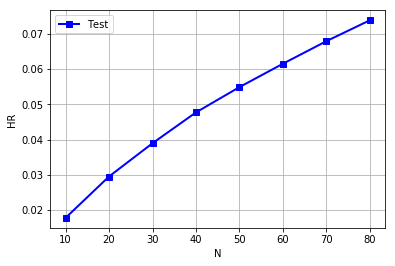

In [26]:
plt.plot(k_list, hr_test, label='Test', linewidth=2, marker='s', c='b')
plt.xlabel('N')
plt.ylabel('HR')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

- **MAP@*k***

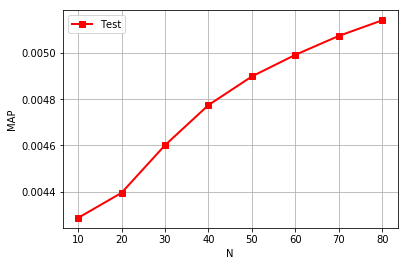

In [27]:
plt.plot(k_list, map_test, label='Test', linewidth=2, marker='s', c='r')
plt.xlabel('N')
plt.ylabel('MAP')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

- **NDCG@*k***

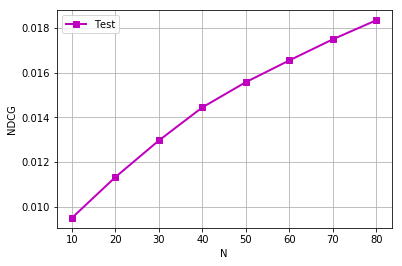

In [28]:
plt.plot(k_list, ndcg_test, label='Test', linewidth=2, marker='s', c='m')
plt.xlabel('N')
plt.ylabel('NDCG')
plt.legend(loc='best')
plt.grid(True)
plt.show()
plt.close()

# Prediction

Do **top-N** recommendations for real customers/items.

In [29]:
fm.predict()

array([[ 1.63612083e+00,  3.47763977e-01, -2.32685717e-01, ...,
         7.08755665e-02, -8.19420623e-02, -1.06879529e-01],
       [-3.03219962e-01,  3.87919074e-01, -7.41940857e-01, ...,
         5.15838708e-02, -3.56759513e-02, -1.51383134e-02],
       [ 1.33393985e-02, -3.26598138e-01,  1.00827957e+00, ...,
        -6.30788173e-02, -1.72925957e-02,  8.37648576e-02],
       ...,
       [ 1.76923578e-01,  1.31972147e-01, -6.07008662e-01, ...,
         4.81986822e-02, -2.41990370e-02, -1.05649105e-01],
       [ 1.42283147e-01, -2.13468664e-01,  1.50441403e-01, ...,
         1.45133715e-03, -2.46512605e-03, -6.11925758e-02],
       [ 7.46031219e-03,  6.68911378e-02, -1.79540404e-01, ...,
         8.49449656e-03, -1.16636198e-02, -1.43786176e-02]])

In [30]:
n_samples = 10
sampled_users = np.random.choice(list(user_map.keys()), n_samples)
sampled_users

array(['f22040c5aad21791e044001517f43a86',
       '60c08b0486284a5c94a21ba081a88cd2',
       'c0770034da5640008712b6857b158142',
       '3e3b29fbede8441692965af3856f2352',
       'f18a7ce97e5e4a1ae044001517f43a86',
       'e15f656fcc09435691f6b47b2367a27a',
       'f199bf28dc6b5f88e044001517f43a86',
       'f1a02ae6832e631ee044001517f43a86',
       'f2047b5de005362be044001517f43a86',
       'f0931b41019a1ca0e044001517f43a86'], dtype='<U32')

In [31]:
sampled_user_idxs = list(map(lambda x:user_map.get(x), sampled_users))
sampled_user_idxs

[14001, 22209, 20622, 14669, 17992, 5389, 1460, 31612, 18362, 32886]

In [36]:
fm.recommend(sampled_user_idxs, N=5)

array([[   89,   847, 17703, 27345,   274],
       [ 1227, 10040,   353,   339,  2558],
       [ 1002,   119,  2434,   854,  1227],
       [ 2515,   726,  4622,  2836,  2649],
       [ 1567,    20,  5637,   272,   226],
       [ 2558,  4216,  2697,   524,  2297],
       [ 1672,  3270, 43770, 44854, 45302],
       [ 3369,   524,  1889,    48,  2081],
       [  847, 17703,    89,   274,  1704],
       [ 1660,   594,   309,  3657,  4963]], dtype=uint32)

In [37]:
sampled_items = np.random.choice(list(item_map.keys()), n_samples)
sampled_items

array(['42417753', '29765911', '56134849', '412662382', '138130186',
       '450078542', '10316199', '49850764', '36544314', '36726114'],
      dtype='<U10')

In [38]:
sampled_item_idxs = list(map(lambda x:item_map.get(x), sampled_items))
sampled_item_idxs

[19529, 14876, 21887, 3106, 14310, 37804, 4539, 27790, 3643, 44205]

In [39]:
fm._similar_items(sampled_item_idxs)

array([[37537,  5918, 46655, 46965, 46055],
       [ 2436,  7129, 20718, 15479,  1477],
       [38199, 29707, 47771, 40151, 40032],
       [11129,  9196, 46763, 40661, 13744],
       [38391, 24591, 41521, 36582, 47151],
       [35666, 42700, 38585, 47365, 41675],
       [32167, 14905, 39438, 10031, 33395],
       [ 9102, 33901, 28522, 27423, 43292],
       [15178, 18429,  1134,  6155,  5865],
       [13239, 25967, 44254, 22532, 16691]])

# Reference

1. [Factorization Machines with libFM](https://www.csie.ntu.edu.tw/~b97053/paper/Factorization%20Machines%20with%20libFM.pdf)
2. [libFM 1.4.2 manual](http://www.libfm.org/libfm-1.42.manual.pdf)